In [1]:
# Importing necessary libraries
import json
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
import numpy as np

In [37]:
map_base_dir = '../../model/data/instance-segmentation'
map_img_dir = '../../model/data/instance-segmentation/train/images/'

In [35]:
# Loads the annotation data for the images from a JSON file
json_path = os.path.join(map_base_dir, 'annotation.json')
with open(json_path, 'r') as f:
    annot_data = json.load(f)

In [39]:
# Creates a DataFrame from the image data 
image_df = pd.DataFrame(annot_data['images'])
image_df.sample(3)

,id,file_name,width,height
46567,213923,000000213923.jpg,300,300
129595,91739,000000091739.jpg,300,300
31962,46846,000000046846.jpg,300,300


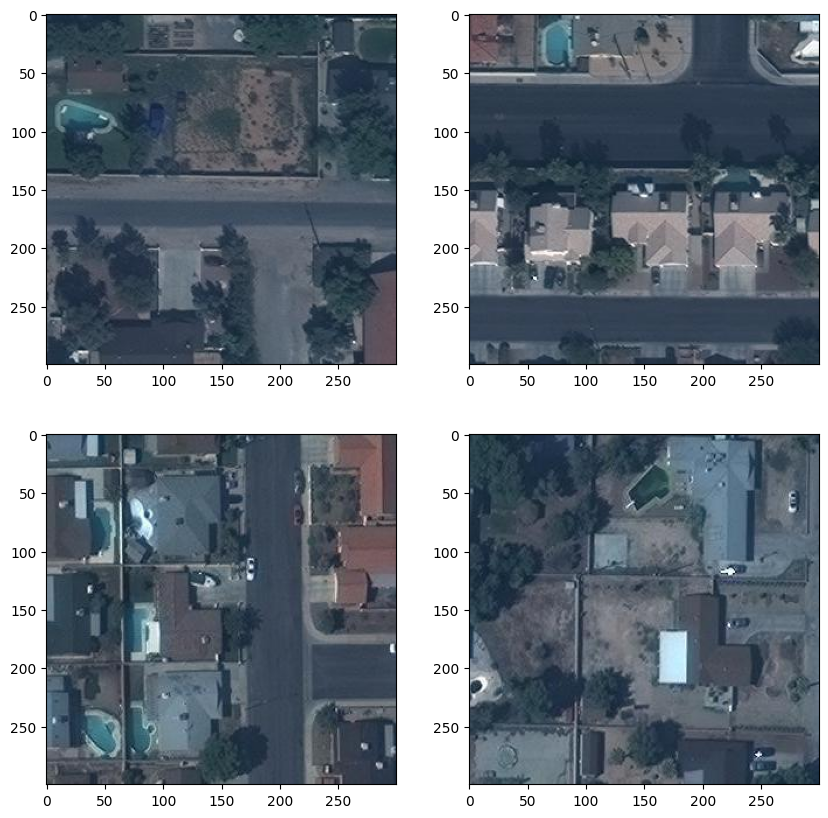

In [41]:
# Visualizes a few sample images from the dataset.
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (_, c_row) in zip(m_axs.flatten(), image_df.sample(4).iterrows()):
    img_data = imread(os.path.join(map_img_dir, c_row['file_name']))
    c_ax.imshow(img_data)

In [43]:
# Creates a DataFrame from annotations data 
annot_df = pd.DataFrame(annot_data['annotations'])
annot_df.sample(3)

,id,image_id,segmentation,area,bbox,category_id,iscrowd
2108486,1281501,150351,"[[204, 300, 204, 289, 240, 289, 240, 300, 204,...",396.0,"[204, 204, 96, 36]",100,0
1267945,302511,35459,"[[164.0, 8.572527594031472e-16, 164.0, 1.00000...",1088.0,"[8.572527594031472e-16, 100.0, 164.0, 64.0]",100,0
1229891,324512,38018,"[[160.0, 226.0, 160.0, 198.0, 181.0, 198.0, 18...",2097.0,"[160.0, 160.0, 66.0, 64.0]",100,0


In [45]:
full_df = pd.merge(annot_df, image_df, how='left', left_on = 'image_id', right_on='id').dropna()
print(image_df.shape[0], '+', annot_df.shape[0], '->', full_df.shape[0])
full_df.sample(2)

280741 + 2395553 -> 2395553


,id_x,image_id,segmentation,area,bbox,category_id,iscrowd,id_y,file_name,width,height
857092,1824250,214026,"[[11, 182, 11, 194, 0, 194, 0, 182, 11, 182]]",132.0,"[0, 0, 194, 11]",100,0,214026,000000214026.jpg,300,300
1976709,2097283,245998,"[[117.0, -2.0206672185931327e-15, 120.0, 17.99...",9980.0,"[-2.0206672185931327e-15, 43.0, 143.0, 99.0]",100,0,245998,000000245998.jpg,300,300


In [51]:
def create_boxes(in_rows):
    box_list = []
    for _, in_row in in_rows.iterrows():
        # bbox from the coco standard
        (start_y, start_x, wid_y, wid_x) = in_row['bbox']
        
        box_list += [Rectangle((start_x, start_y), 
                         wid_y , wid_x
                         )]
    return box_list

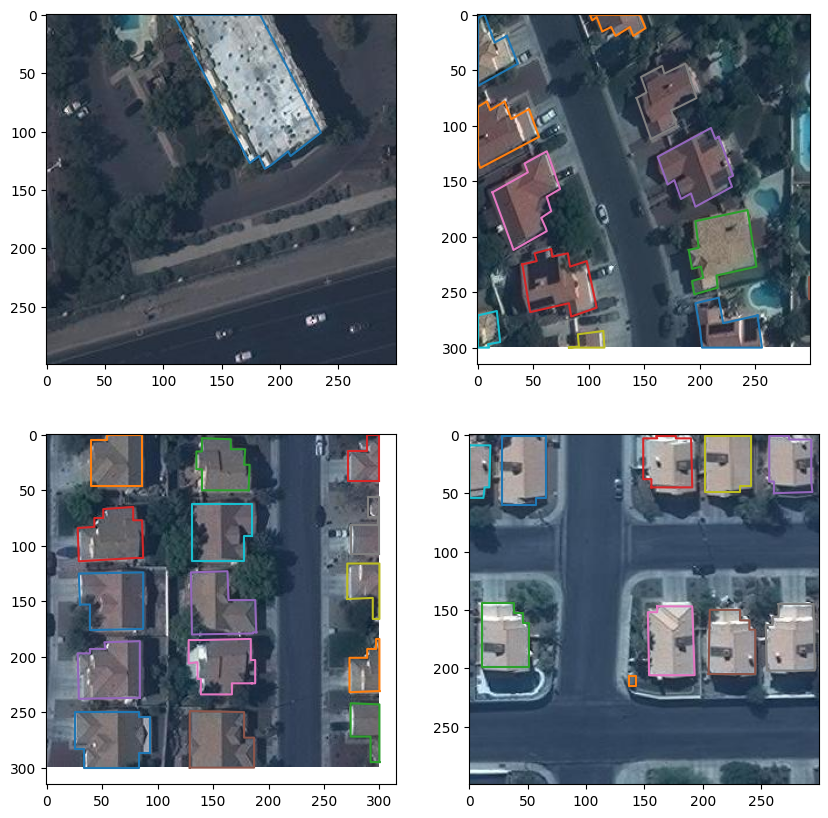

In [53]:
fig, m_axs = plt.subplots(2, 2, figsize = (10, 10))
for c_ax, (c_id, c_df) in zip(m_axs.flatten(), full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    #c_ax.add_collection(PatchCollection(create_boxes(c_df), alpha = 0.25, facecolor = 'red'))
    for _, c_row in c_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])

In [54]:
from matplotlib.path import Path
from skimage.color import label2rgb
def rows_to_segmentation(in_img, in_df):
    xx, yy = np.meshgrid(range(in_img.shape[0]), 
                range(in_img.shape[1]),
               indexing='ij')
    out_img = np.zeros(in_img.shape[:2])
    for _, c_row in in_df.iterrows():
        xy_vec = np.array(c_row['segmentation']).reshape((-1, 2))
        c_ax.plot(xy_vec[:, 0], xy_vec[:, 1], label = c_df['id_x'])
        xy_path = Path(xy_vec)
        out_img += xy_path.contains_points(np.stack([yy.ravel(), 
                                                     xx.ravel()], -1)).reshape(out_img.shape)
    return out_img

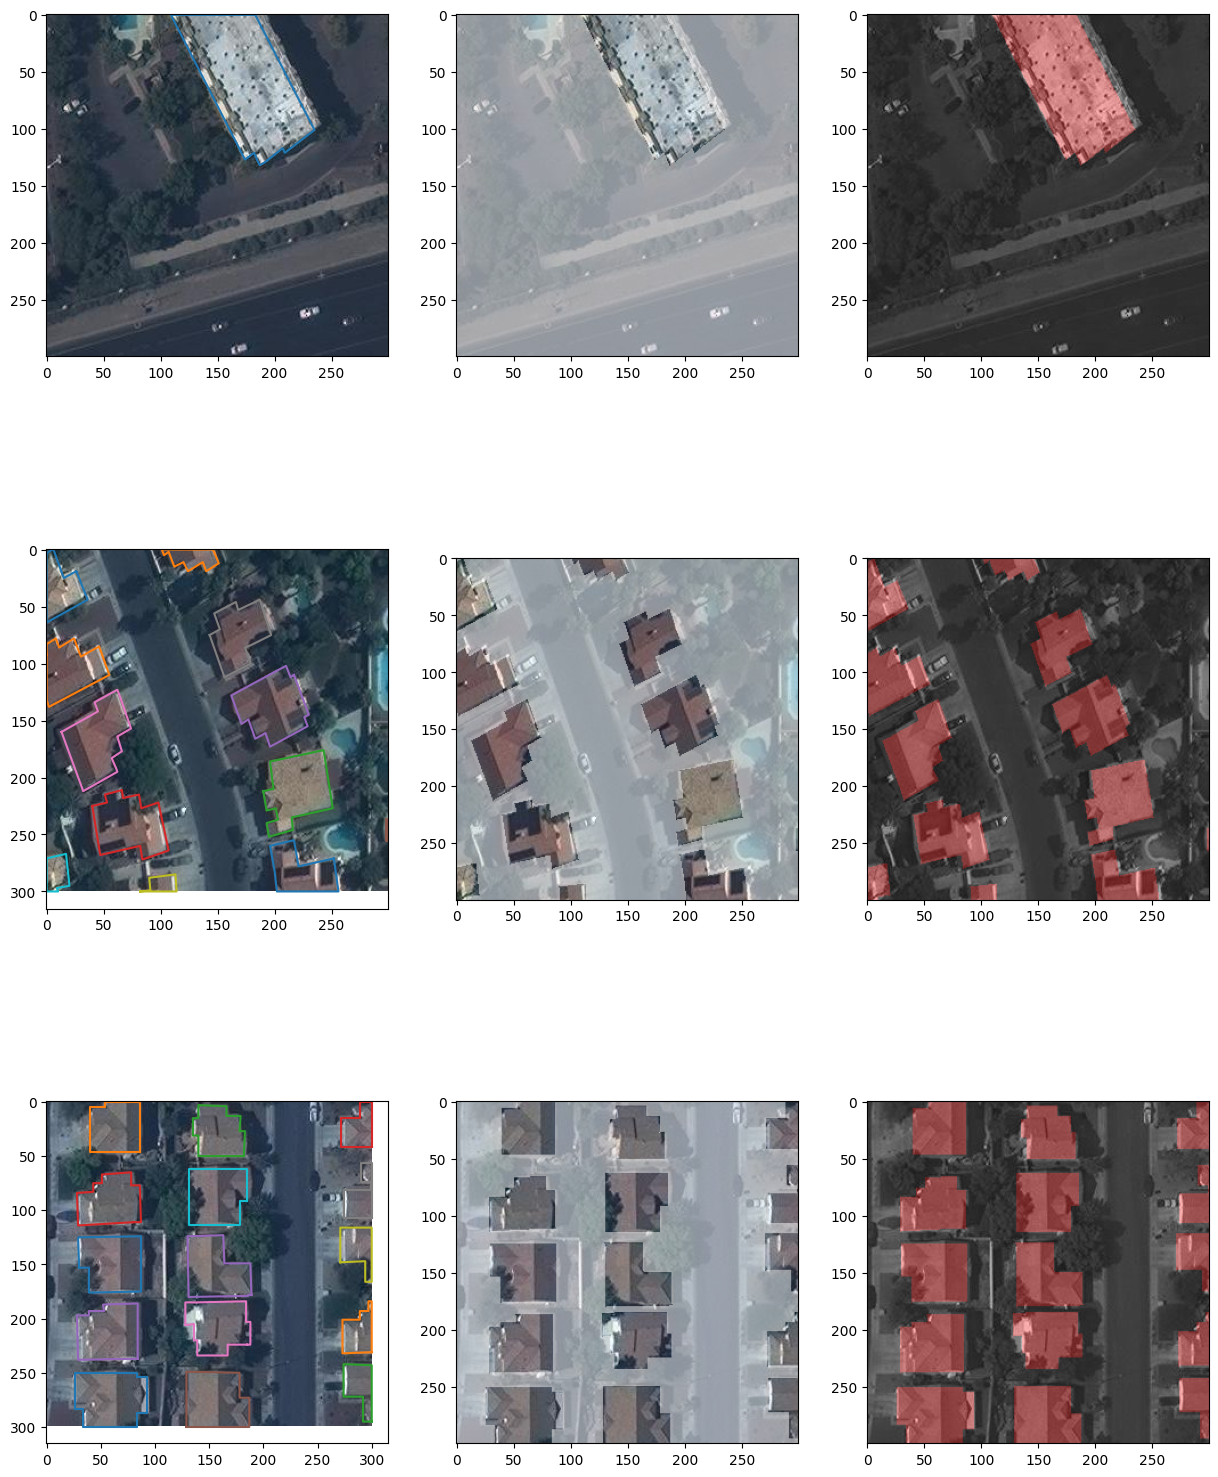

In [55]:
fig, m_axs = plt.subplots(3, 3, figsize = (15, 20))
for (c_ax, d_ax, f_ax), (c_id, c_df) in zip(m_axs,
                                      full_df.groupby('image_id')):
    img_data = imread(os.path.join(map_img_dir, c_df['file_name'].values[0]))
    c_ax.imshow(img_data)
    out_img = rows_to_segmentation(img_data, c_df)
    rgba_img = np.concatenate([img_data, 
                               np.clip(np.expand_dims(127*out_img+127, -1), 0, 255).astype(np.uint8)
                              ], -1)
    d_ax.imshow(rgba_img)
    
    f_ax.imshow(label2rgb(image=img_data, label=out_img, bg_label = 0))